In [1]:
# fill namespace with nupy and matplotlib + static notebook plots
%pylab inline
# fill namespace with nupy and matplotlib + and interactive plots
#%pylab notebook 
#%matplotlib qt
from __future__ import division # use so 1/2 = 0.5, etc.
import sk_dsp_comm.sigsys as ss
import sk_dsp_comm.digitalcom as dc
import sk_dsp_comm.rtlsdr_helper as sdr
import imp # for module reloading
import scipy.signal as signal
from IPython.display import Audio, display
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['savefig.dpi'] = 100 # default 72
#pylab.rcParams['figure.figsize'] = (6.0, 4.0) # default (6,4)
#%config InlineBackend.figure_formats=['png'] # default for inline viewing
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX
#Image('fname.png',width='80%')

# Capture NOAA Weather Radio
Using `rtlsdr_helper` record a short complex baseband array using `capture()`.

In [3]:
# From the docstring
#x = sdr.capture(Tc, fo=88700000.0, fs=2400000.0, gain=40, device_index=0)
x = sdr.capture(Tc=5,fo=162.4e6,fs=2.4e6,gain=40,device_index=0)

In [5]:
sdr.complex2wav('capture_162475.wav',2400000,x)

Saved as binary wav file with (I,Q)<=>(L,R)


In [9]:
fs, x = sdr.wav2complex('capture_162475.wav')

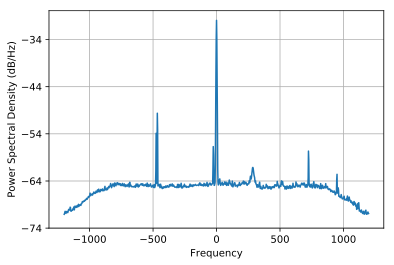

In [10]:
psd(x,2**10,2400);

## Narrowband FM Demodulator

In [5]:
def NBFM_demod(x,fs=2.4e6,file_name='test.wav',B1=50e3,N1=10,B2=5e3,N2=5):
    """
    Narrowband FM Demodulator
    """
    b = signal.firwin(64,2*B1/float(fs))
    # Filter and decimate (should be polyphase)
    y = signal.lfilter(b,1,x)
    z = ss.downsample(y,N1)
    # Apply complex baseband discriminator
    z_bb = sdr.discrim(z)
    z_bb -= mean(z_bb)
    # Design 2nd decimation lowpass filter
    bb = signal.firwin(64,2*B2/(float(fs)/N1))
    # Filter and decimate
    zz_bb = signal.lfilter(bb,1,z_bb)
    # Decimate by N2
    z_out = ss.downsample(zz_bb,N2)
    # Save to wave file
    ss.to_wav(file_name, 48000, z_out)
    print('Done!')
    return z_bb, z_out

In [14]:
z_bb, z_demod = NBFM_demod(x,file_name='NOAA_cos_demod.wav')

Done!


(-80, -20)

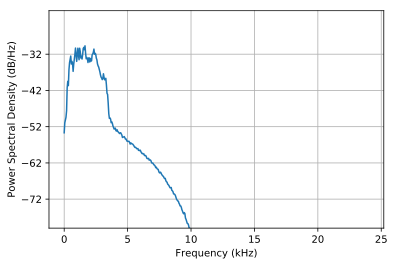

In [12]:
psd(z_demod,2**10,2400/50);
xlabel(r'Frequency (kHz)');
ylim([-80,-20])

In [15]:
Audio('NOAA_cos_demod.wav')